# 100k Events with latest detector configuration

100k events span runs 320.

Creating the MuonDataFrame Objects and DataFrames.

In [93]:
from MuonDataFrame import *

isNew = "False"

f1 = "processed_data/events_data_frame_320.h5"
f2 = "processed_data/events_data_frame_321.h5"
#f3 = "processed_data/events_data_frame_302.h5"

mdfo0 = MuonDataFrame(f1, isNew=isNew, d1="last")
mdfo1 = MuonDataFrame(f2, isNew=isNew, d1="last")
#mdfo2 = MuonDataFrame(f3, isNew=isNew, d1="last")

In [94]:
mdf0 = mdfo0.events_df
mdf1 = mdfo1.events_df
#mdf2 = mdfo2.events_df

Creating seperate .csv files

In [95]:
mdfo0.getCompleteCSVOutputFile()
mdfo1.getCompleteCSVOutputFile()
#mdfo2.getCompleteCSVOutputFile()

processed_data/events_data_frame_320.csv has been created
processed_data/events_data_frame_321.csv has been created


Merging all the runs together and generating a .csv file

In [96]:
#mdf_list = [mdf0,mdf1,mdf2]
mdf_list = [mdf0,mdf1]

mdf1M = mdfo0.getMergedMDF(mdf_list)
mdf1M.to_csv("processed_data/run3X2.csv", header=True, index=False)

Creating a report pdf for all events combined together.

In [91]:
import copy

#mdf_list = [mdf0,mdf1,mdf2]
mdf_list = [mdf0,mdf1]
mdf1M = mdfo0.getMergedMDF(mdf_list)

mdfo1M = copy.copy(mdfo0)
mdfo1M.events_df = mdf1M

In [92]:
mdfo1M.generateAnaReport("run3X2.pdf")

Creating the report pdf...
The report file run3X2.pdf has been created.


## General Report Observations

1. The relative heights of asymmetry and difference peaks are not the same.

2. Tray 4 difference peaks not the same width

3. Tray 4 asymmetry peaks is wider than the widths of the first three trays. **(May be due to smaller sums and poor PMTs?)**

4. Taking events that are within some small neigborhood of mean of sumTDC don't reflect actual good events.

5. Zenith angular distribution (see below)

6. Noise in finger plots **(I can't explain)**


## Analysis of Run

### Looking at number of events with multiple TDC Hits

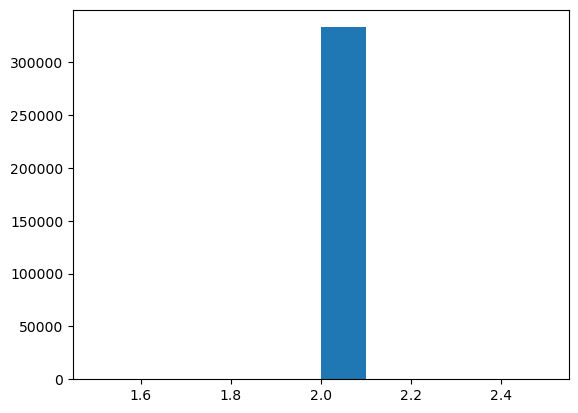

In [4]:
x = mdfo0.get("TDC")

l = []
for i in x:
    for j in i:
        l.append(len(j))

plt.hist(l)
plt.show()

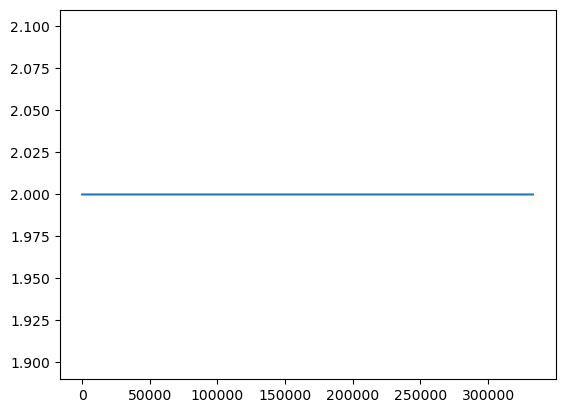

In [5]:
plt.plot([i for i in range(len(l))],l)
plt.show()

### Generating Image of Small Counter

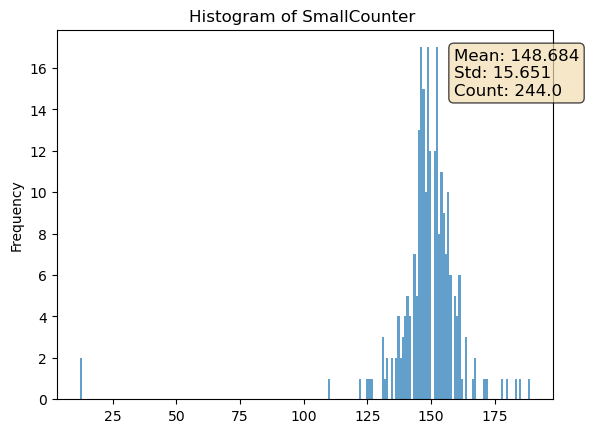

In [14]:
mdfo0.getHistogram("SmallCounter")

It is really bizarre that we are getting 1 value only.

## Angular Distribution

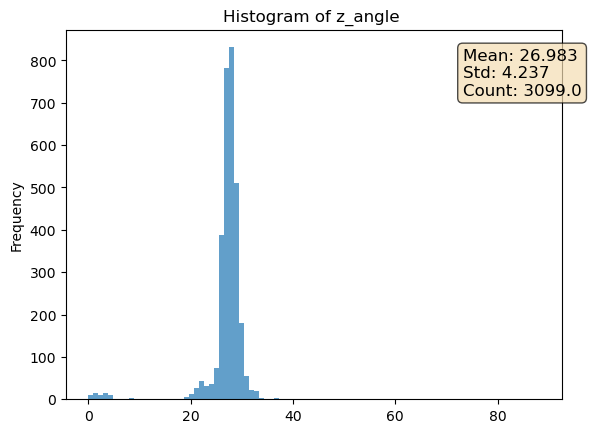

In [42]:
mdfo0.getHistogram("z_angle",nbins=90)

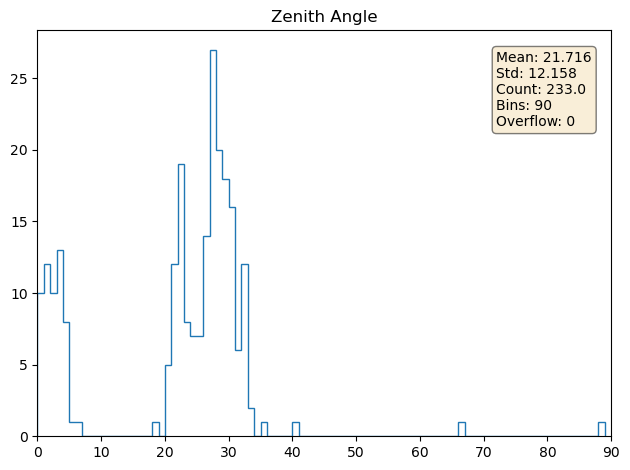

In [41]:
mdfo0.getZView()

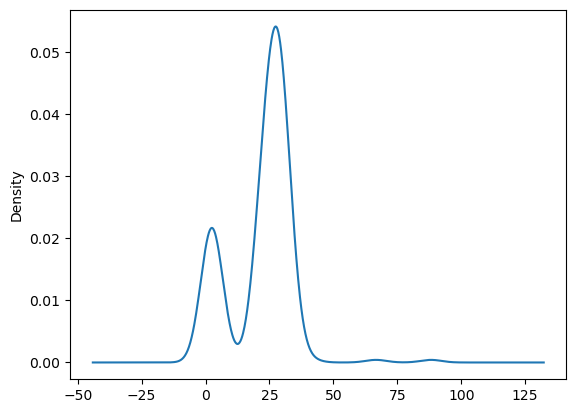

In [48]:
import copy

mdfo_test = copy.copy(mdfo0)
mdfo_test.keep4by4Events()
z_angles = mdfo_test.get("z_angle")
mdfo_test.events_df["z_angle"].plot(kind="kde")
plt.show()

### need to compare with expected angles

# Angles from Edge Hits

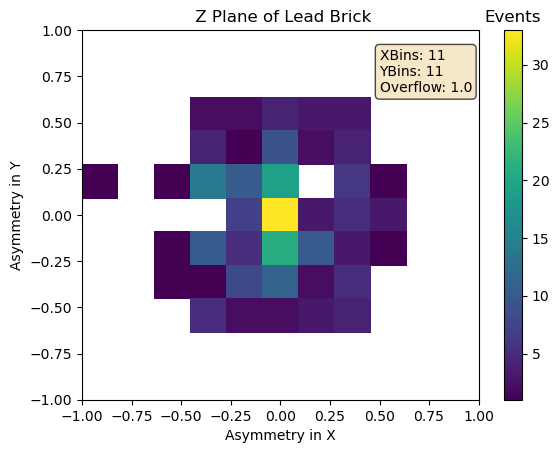

In [49]:
mdfo_test2 = copy.copy(mdfo0)
mdfo_test2.get2DTomogram()

In [50]:
def getCorrelationPlot(mdfo, query_list, nbins=1000, title=""):
    xmin = -0.65
    xmax = 0.65
    ymin = -0.65
    ymax = 0.65
    mdfo.get2DHistogram(mdfo.events_df[query_list[0]].values,
                        mdfo.events_df[query_list[1]].values,
                        "{}".format(title), "{}".format(query_list[0]),
                        "{}".format(query_list[1]), xmin, xmax, ymin, ymax,
                        nbins, False)

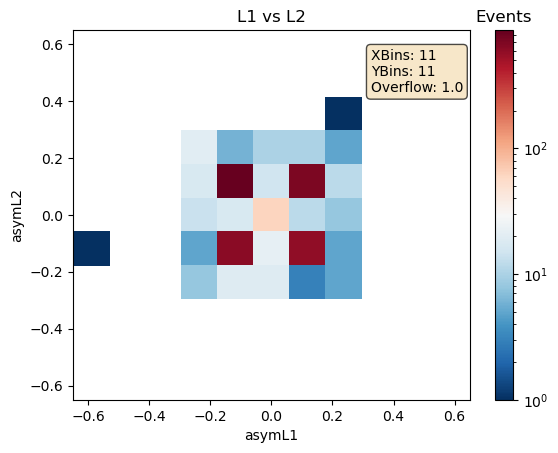

In [59]:
getCorrelationPlot(mdfo_test2, ["asymL1","asymL2"],nbins=11,title="L1 vs L2")

## Angular distribution for edge events

### Keeping events from top left and right hit clusters

In [79]:
def getAngularDistributionFromAsymCuts(mdfo,asym_list,asym_ranges):
    mdfo.reload()
    mdfo.keepEvents(asym_list[0],asym_ranges[0][0],">=")
    mdfo.keepEvents(asym_list[0],asym_ranges[0][1],"<=")
    mdfo.keepEvents(asym_list[1],asym_ranges[1][0],">=")
    mdfo.keepEvents(asym_list[1],asym_ranges[1][1],"<=")
    mdfo.getHistogram("z_angle",nbins=90, title="(All)")
    mdfo.getZView()
    mdfo.reload()

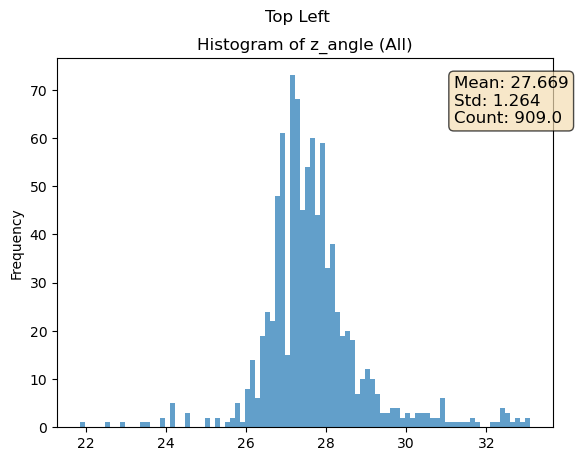

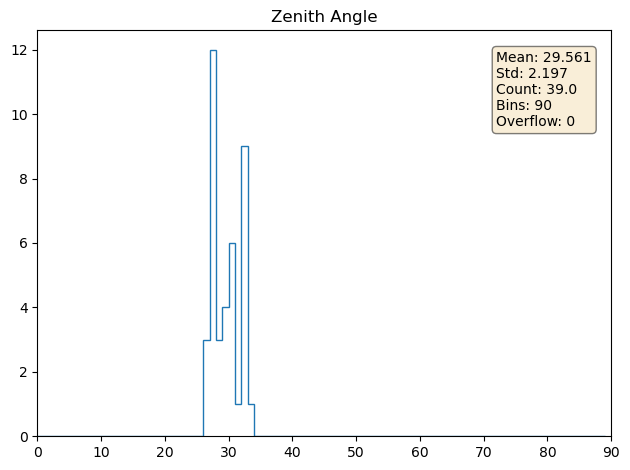

In [82]:
plt.suptitle("Top Left")
getAngularDistributionFromAsymCuts(mdfo_test2,["asymL1","asymL2"],[(-0.2,-0.12),(0.12,0.2)])

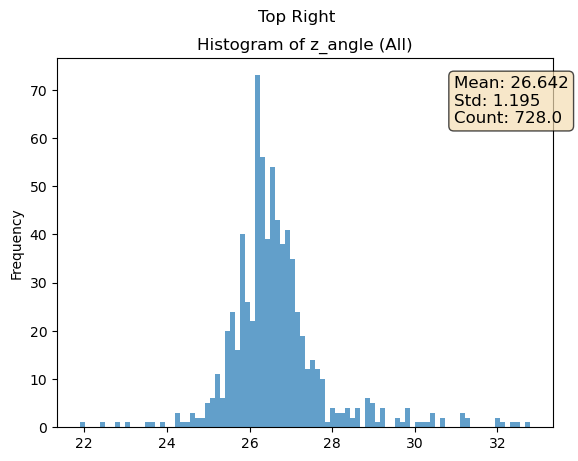

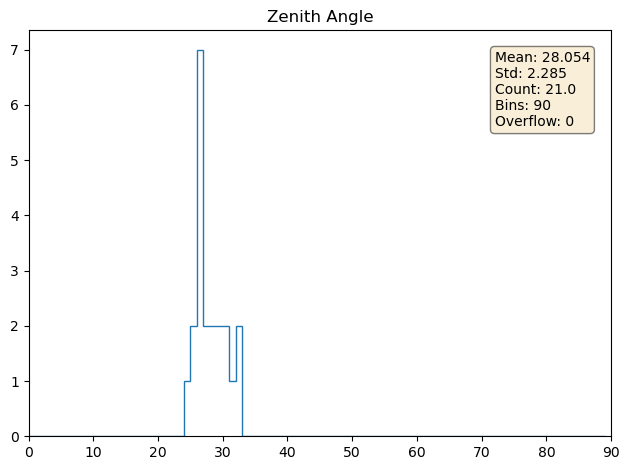

In [83]:
plt.suptitle("Top Right")
getAngularDistributionFromAsymCuts(mdfo_test2,["asymL1","asymL2"],[(0.12,0.2),(0.12,0.2)])

### Keeping events from bottom left and bottom hit clusters

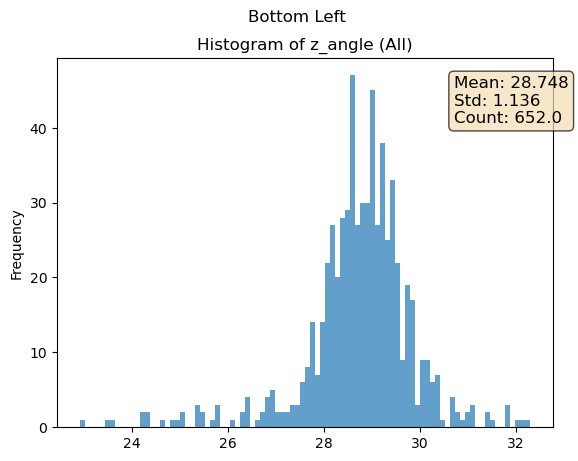

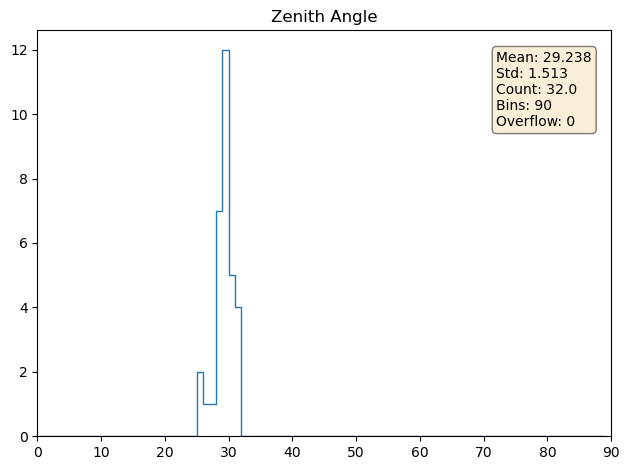

In [84]:
plt.suptitle("Bottom Left")
getAngularDistributionFromAsymCuts(mdfo_test2,["asymL1","asymL2"],[(-0.2,-0.12),(-0.2,-0.12)])

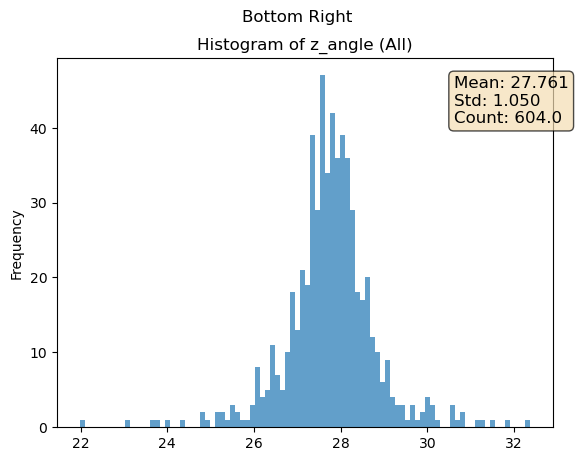

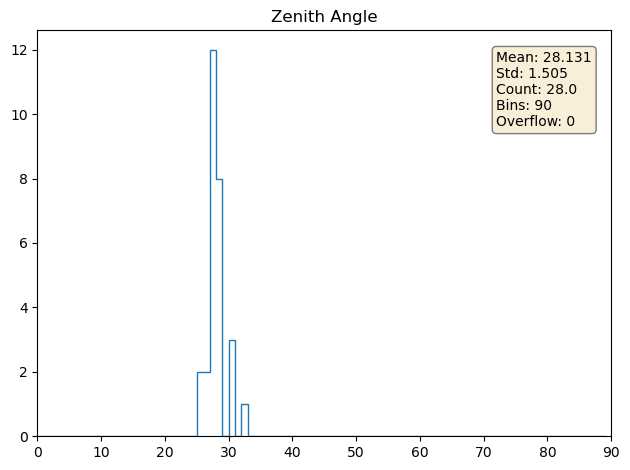

In [85]:
plt.suptitle("Bottom Right")
getAngularDistributionFromAsymCuts(mdfo_test2,["asymL1","asymL2"],[(0.12,0.2),(-0.2,-0.12)])

### Fitted Peaks Analysis

Long story short, we need some reasoned decision that is not purely geometrical in order to make the decision of which peaks to discard.

In [21]:
from scipy.signal import find_peaks, peak_prominences

def getPD(term,df,bw):
    df[term].plot.kde(bw_method=bw)
    plt.title(term)
    plt.xlim([-0.25, 0.25])
    plt.show()
    
def getHisto(term,df,bins,bw=0.01):
    df[term].plot.hist(bins=bins, density=True, range=[-0.25, 0.25])
    plt.title(term)
    plt.show()
    
def getNPHist(df, term, bins, range=(-0.25, 0.25)):
    values = df[term]
    hist, bin_edges = np.histogram(values, bins, range=range)
    bin_edges = bin_edges[1:]
    return hist, bin_edges


def getPeaks(x, prmc, wdth):
    peaks, properties = find_peaks(x, prominence=prmc, width=wdth)
    properties["prominences"], properties["widths"]

    plt.plot(x)
    plt.plot(peaks, x[peaks], "x")

    plt.vlines(x=peaks,
           ymin=x[peaks] - properties["prominences"],
           ymax=x[peaks],
           color="C1")

    plt.hlines(y=properties["width_heights"],
           xmin=properties["left_ips"],
           xmax=properties["right_ips"],
           color="C1")
    plt.show()

### Clean Data Analysis

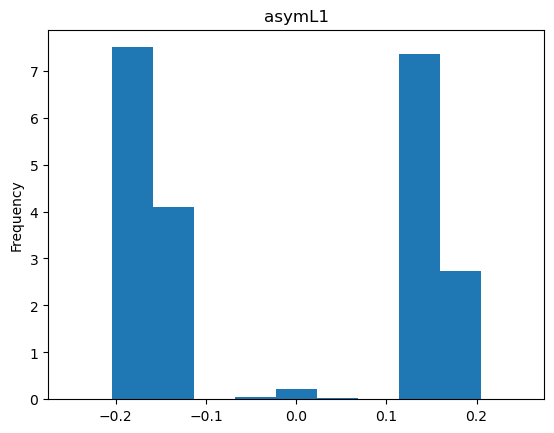

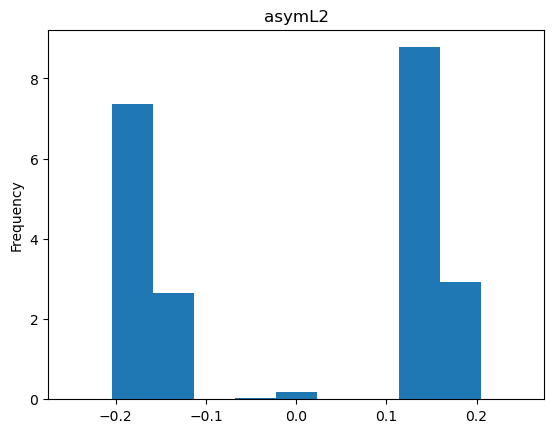

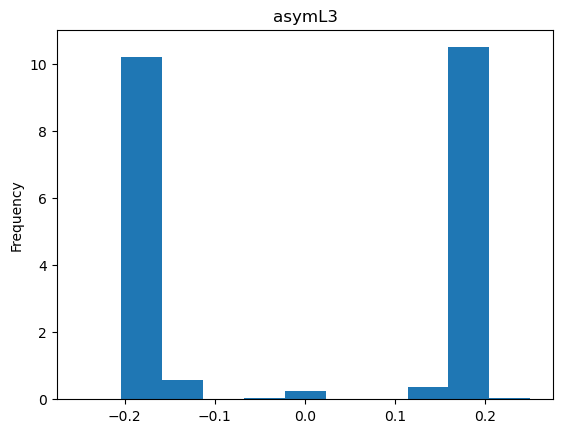

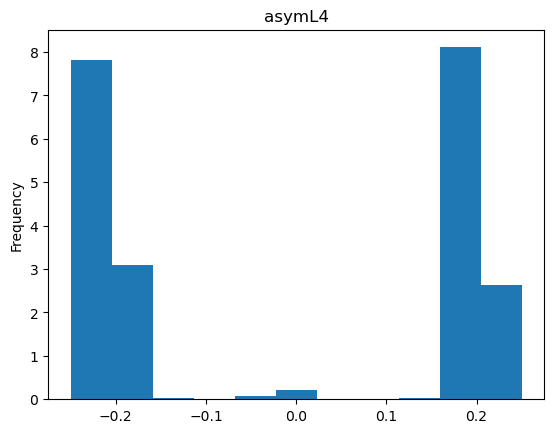

In [23]:
getHisto("asymL1",mdf0,11)
getHisto("asymL2",mdf0,11)
getHisto("asymL3",mdf0,11)
getHisto("asymL4",mdf0,11)

### Creating a Calibration Table using insights from TDC channels study

Study the tdc_study.ipynb and make a plan for the study in this section. *Take input from Dr. Akchurin*